# **LightGBM to predict Healthcare Costs**


Import and Load Libraries

In [1]:
!pip install lightgbm

import seaborn as sns
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tabulate import tabulate

import joblib

Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Files

In [3]:
# Define the correct folder path
base_path = "/content/drive/MyDrive/Capstone Project/Data/"

# Load feature datasets
X_train = pd.read_csv(base_path + "features_train.csv")
X_test = pd.read_csv(base_path + "features_test.csv")

# Load cost datasets (y values) and flatten them
y_train = pd.read_csv(base_path + "cost_train.csv").values.ravel()
y_test = pd.read_csv(base_path + "cost_test.csv").values.ravel()

# Verify dataset shape
print(f"Training Features: {X_train.shape}, Training Labels: {y_train.shape}")
print(f"Test Features: {X_test.shape}, Test Labels: {y_test.shape}")

Training Features: (1492974, 138), Training Labels: (1492974,)
Test Features: (639847, 138), Test Labels: (639847,)


In [4]:
# Convert datasets to LightGBM format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

Train the LightGBM Model on GPU

In [9]:
params = {
    'objective': 'regression',  # Same as 'reg:squarederror' in XGBoost
    'metric': 'rmse',           # Same evaluation metric
    'boosting_type': 'gbdt',    # Gradient Boosting Decision Trees (similar to XGBoost)
    'device': 'cpu',            # Runs on GPU like XGBoost’s 'device': 'cuda'
    'learning_rate': 0.05,      # Step size shrinkage
    'max_depth': 10,            # Prevents overfitting (same as XGBoost)
    'num_leaves': 600,          # Equivalent to tree depth complexity
    'feature_fraction': 0.8,    # Matches "max_features" in XGBoost
    'verbosity': -1             # Suppresses unnecessary logs
}

In [10]:
lgbm_model = lgb.train(
    params,
    train_data,
    num_boost_round=100
)

In [11]:
# Make predictions using the trained LightGBM model
y_pred = lgbm_model.predict(X_test)

In [12]:
#Calculate evaluation metrics for consistency
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results using tabulate
print("LightGBM Model Performance:")
print(tabulate([
    ["MSE", f"{mse:.2f}"],
    ["RMSE", f"{rmse:.2f}"],
    ["R²", f"{r2:.4f}"]],
    headers=["Metric", "Value"],
    tablefmt="rounded_outline"))

LightGBM Model Performance:
╭──────────┬─────────╮
│ Metric   │   Value │
├──────────┼─────────┤
│ MSE      │  0.18   │
│ RMSE     │  0.43   │
│ R²       │  0.8173 │
╰──────────┴─────────╯


Feature Importance

In [ ]:
# Extract feature importance and feature names
feature_importance_df = pd.DataFrame({
    'Feature':  X_train.columns,
    'Importance': lgbm_model.feature_importance()
})

# Sort by importance (higher values = more important)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
importance_thresholds = [0.98, 0.95, 0.90]
results = {}
for threshold in importance_thresholds:
  feature_importance_df['cumulative_importance'] = feature_importance_df['Importance'].cumsum() / feature_importance_df['Importance'].sum()
  selected_features = feature_importance_df[feature_importance_df['cumulative_importance'] <= threshold]['Feature'].tolist()
  X_train_selected = X_train[selected_features]
  X_test_selected = X_test[selected_features]

  # Convert to LightGBM datasets
  train_data_selected = lgb.Dataset(X_train_selected, label=y_train)
  test_data_selected = lgb.Dataset(X_test_selected, label=y_test, reference=train_data_selected)

  # Train a new LightGBM model with the selected features
  params = {
      'objective': 'regression',
      'metric': 'rmse',
      'boosting_type': 'gbdt',
      'device': 'cpu',
      'learning_rate': 0.05,
      'max_depth': 6,
      'num_leaves': 31,
      'feature_fraction': 0.8,
      'verbosity': -1
  }

  lgbm_model_selected = lgb.train(
      params,
      train_data_selected,
      num_boost_round=100,
      valid_sets=[test_data_selected],
  )

  # Make predictions
  y_pred_selected = lgbm_model_selected.predict(X_test_selected)

  # Calculate Metrics
  mse = mean_squared_error(y_test, y_pred_selected)
  rmse = np.sqrt(mse)
  r2_score_value = r2_score(y_test, y_pred_selected)

  # Store results
  results[threshold] = {
      'n_features': len(selected_features),
      'mse': mse,
      'rmse': rmse,
      'r2_score': r2_score_value,
      'features': selected_features
  }

In [ ]:
# Print results
for threshold, metrics in results.items():
  print(tabulate([
      [f"Threshold: {threshold}"],
      [f"Number of Features: {metrics['n_features']}"],
      [f"MSE: {metrics['mse']:.2f}"],
      [f"RMSE: {metrics['rmse']:.2f}"],
      [f"R² Score: {metrics['r2_score']:.4f}"]],
      headers=["Metric", "Value"],
      tablefmt="rounded_outline"))

╭─────────────────────────╮
│ Metric                  │
├─────────────────────────┤
│ Threshold: 0.98         │
│ Number of Features: 102 │
│ MSE: 0.27               │
│ RMSE: 0.52              │
│ R² Score: 0.7266        │
╰─────────────────────────╯
╭────────────────────────╮
│ Metric                 │
├────────────────────────┤
│ Threshold: 0.95        │
│ Number of Features: 87 │
│ MSE: 0.27              │
│ RMSE: 0.52             │
│ R² Score: 0.7255       │
╰────────────────────────╯
╭────────────────────────╮
│ Metric                 │
├────────────────────────┤
│ Threshold: 0.9         │
│ Number of Features: 72 │
│ MSE: 0.28              │
│ RMSE: 0.52             │
│ R² Score: 0.7245       │
╰────────────────────────╯


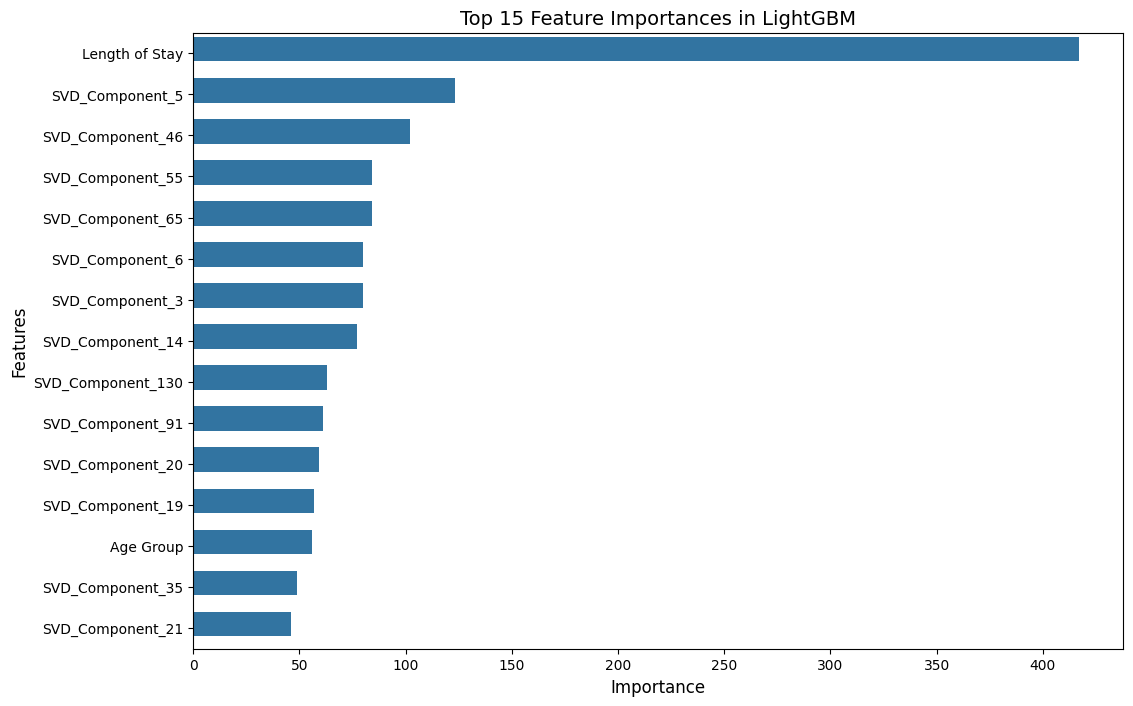

In [ ]:
# Set figure size
plt.figure(figsize=(12, 8))

# Get the top 15 most important features
top_features = feature_importance_df.head(15)

# Create a horizontal barplot with a single color (solid blue)
sns.barplot(x='Importance', y='Feature', data=top_features)

# Add title and labels
plt.title("Top 15 Feature Importances in LightGBM", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Adjust bar width
for patch in plt.gca().patches:
    patch.set_height(0.6)  # Controls thickness of bars

# Show plot
plt.show()

Save Model

In [ ]:
drive_path = "/content/drive/My Drive/Capstone Project/Code/Models/RandomForest/rf_model.joblib"
joblib.dump(lgbm_model, drive_path)
print(f"Model saved to Google Drive: {drive_path}")

Model saved to Google Drive: /content/drive/My Drive/Capstone Project/Code/Models/RandomForest/rf_model.joblib
